In [1]:
from sklearn.datasets import fetch_openml
import os

DIGITS_PATH = os.path.join("datasets", "digits")

def fetch_digits_data(openml_name, version_num, digits_path=DIGITS_PATH):
    os.makedirs(digits_path, exist_ok=True)
    
    mnist = fetch_openml(openml_name, version=version_num, data_home=digits_path)
    return mnist

mnist = fetch_digits_data("mnist_784", 1)

In [2]:
# Some of the keys in the dataset are common for Scikit-Learn, like:
# - DESCR, describing the dataset
# - data, containing an array with one row per instance and one column per feature
# - target, containing an array with the labels

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# We grab the data and labels

X, y = mnist["data"], mnist["target"]
print("Shape X:", X.shape)
print("Shape y:", y.shape)

Shape X: (70000, 784)
Shape y: (70000,)


The dataset contains 70,000 images of hand-written digits, each with 28*28 pixels

Raw shape of digit: (784,)
Shape of associated image: (28, 28)


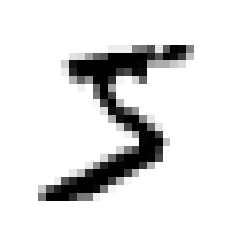

The digit in the image is a 5


In [4]:
# We inspect one of the digits, or rather the associated image & label

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
print("Raw shape of digit:", some_digit.shape)
some_digit_image = some_digit.reshape(28,28)
print("Shape of associated image:", some_digit_image.shape)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

print("The digit in the image is a", y[0])

In [5]:
# Since most ML algorithms expect numbers, we cast the labels from string to integer

import numpy as np

y = y.astype(np.uint8)

In [6]:
# The MNIST dataset is already shuffled and split into training and test sets, so we say 'Thank you'

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

For now, let's simplify the task and only try to identify the number 5.

In [7]:
# We create boolean masks for the 5-ness of our labels

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
# We pick a Stochastic Gradient Descent (SDG) classifier for our first attempt. 
# It handles each training instance independently and is thus
# - efficient at dealing with large datasets
# - good for online learning

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Does it recognize the 5 we looked at earlier?

In [9]:
sgd_clf.predict([some_digit])

array([ True])

Nice. Let's use cross-validation to get a better feel for the accuracy of this classifier.

In [10]:
# This is how we might implement cross-validation ourselves

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    # Printing out the indices is of course not necessary, but I find it instructive
    print("Train index:", train_index)
    print("Test index:", test_index)
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred), "\n")

Train index: [    1     3     4 ... 59994 59996 59998]
Test index: [    0     2     6 ... 59995 59997 59999]
0.9669 

Train index: [    0     2     3 ... 59997 59998 59999]
Test index: [    1    10    11 ... 59988 59989 59991]
0.91625 

Train index: [    0     1     2 ... 59995 59997 59999]
Test index: [    3     4     5 ... 59994 59996 59998]
0.96785 



In [11]:
# But if we don't need lots of control over the cross-validation, we might as well use cross_val_score()

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

95+% accuracy on all folds? Madness! But let's not get ahead of ourselves. Even a classifier that predicts that no digit is a '5' would get accuracy values around 90%, as evidenced by the following classifier & results.

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        # We just return False, len(X) times
        return np.zeros((len(X), 1), dtype=bool) 
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

So yeah... This shows why accuracy is generally not a great performance measure for classifiers, especially when dealing with skewed datasets such as the one we turned ours into.

In [13]:
# Confusion matrices are generally a better way of evaluating a classifier.
# Because we don't wanna whip out our test set just yet, but also don't want to evaluate the classifier on 
# data it saw during training, we use cross_val_predict(), which performs K-fold-cv but returns the
# predictions made on each fold, not the accuracy. 

from sklearn.model_selection import cross_val_predict 

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
# Now that y_train_pred contains predictions for all of our training data, we can compute the confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

, where the top row accounts for the "actual negative class", whereas the left column accounts for the "predicted negative class".

This is instructive, but some more concise metrics include
- Precision: (TP/(TP + FP))
- Recall:    (TP/(TP+FN))

In [15]:
# Let's evaluate the precision & recall of our basic Stochastic Gradient Descent classifier

from sklearn.metrics import precision_score, recall_score

print("Precision:\t", precision_score(y_train_5, y_train_pred))
print("Recall:\t\t", recall_score(y_train_5, y_train_pred))

Precision:	 0.8370879772350012
Recall:		 0.6511713705958311


This doesn't look as great as the 95+ accuracy percentages we got earlier. 

If we want a single value for evaluation, e.g. when comparing two classifiers, metrics like the F_1 score (harmonic mean of precision and recall) come in handy. The harmonic mean often is more suitable than the "default" mean, since it gives much more weight to low values, thus requiring both precision and recall to be high to yield a high result. 

If P is our precision and R is our recall, we get the following formula for the F_1 score:

F_1 = 2 / ((1/P) + (1/R)) = 2 * ((P*R)/(P+R))

In [16]:
# Getting the f1_score is simple, thanks to the f1_score() function

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

Note: The F_1 score favors classifiers that have similar precision and recall and is thus suitable when that is what we want.

In [17]:
# Before we do anything else, let's save even this basic model, because we know it's good practice

import joblib

joblib.dump(sgd_clf, "models/digits/stochastic_gradient_descent.pkl", compress=9)

['models/digits/stochastic_gradient_descent.pkl']

There's a trade-off between precision and recall. What if we want to favor one over the other?
The SGD classifier computes a score for each instance, based on a decision function. In our examples, all digits with a score above a certain threshold are classified as '5'. How can we set the threshold?

In [18]:
# Instead of calling the classifier's predict() method, we can call its decision_function() method, and
# then use any threshold we like to classify each instance. 

y_scores = sgd_clf.decision_function([some_digit])
print("Score:", y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print("Prediction if threshold=0:\t", y_some_digit_pred)

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print("Prediction if threshold=8000:\t", y_some_digit_pred)

Score: [2164.22030239]
Prediction if threshold=0:	 [ True]
Prediction if threshold=8000:	 [False]


So choosing the right threshold for our needs is important. How do we decide which threshold to use?

In [19]:
# We start by getting the scores of all instances in the training set via cross_val_predict, with the 
# method parameter set to "decision_function"

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [20]:
# We can then compute precision and recall for all possible thresholds

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [21]:
# We can now identify the highest recall/precision for which we reach a certain precision, e.g. 90%

# Note that np.argmax returns the first index at which (predictions>0.90) is "True"
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

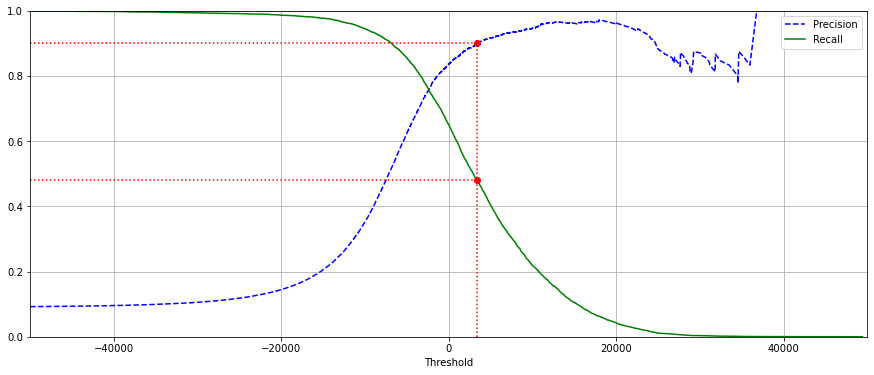

In [22]:
# Finally, we plot precision and recall as functions of the threshold value

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(thresholds, precisions[:-1], "b--", label="Precision")
    ax.plot(thresholds, recalls[:-1], "g-", label="Recall")
    ax.set_xlim([-50000,50000])
    ax.set_ylim([0., 1.])
    plt.xlabel("Threshold")
    plt.legend()
    
    # Let's highlight the largest recall/threshold for which we get 90% precision
    ax.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
    ax.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
    ax.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
    
    ax.plot([threshold_90_precision], [recall_90_precision], "ro")
    ax.plot([threshold_90_precision], [0.9], "ro")
    
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

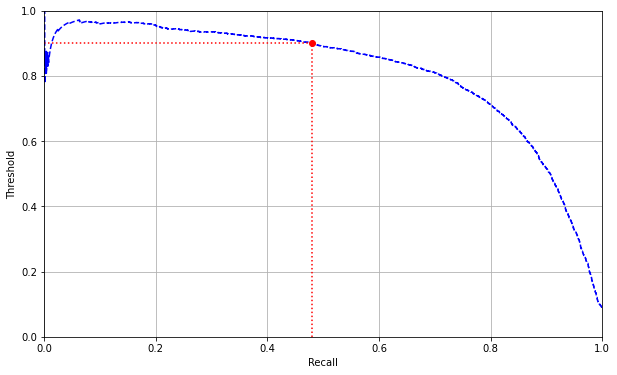

In [23]:
# Another way of showing the trade-off is to plot precision directly against recall

def plot_precision_vs_recall(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(recalls[:-1], precisions[:-1], "b--")
    ax.set_xlim([0., 1.])
    ax.set_ylim([0., 1.])
    plt.xlabel("Recall")
    plt.ylabel("Threshold")
    
    # Let's again highlight the largest threshold for which we get 90% precision
    ax.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    ax.plot([0., recall_90_precision], [0.9, 0.9], "r:")
    
    ax.plot([recall_90_precision], [0.9], "ro")
    
    plt.grid()
    
plot_precision_vs_recall(precisions, recalls, thresholds)
plt.show()

In [24]:
# We can also use the threshold_90_precision to make predictions with 90% accuracy, with the highest recall
# possible

y_train_pred_90 = (y_scores >= threshold_90_precision)

print("Precision:\t", precision_score(y_train_5, y_train_pred_90))
print("Recall:\t\t", recall_score(y_train_5, y_train_pred_90))

Precision:	 0.9000345901072293
Recall:		 0.4799852425751706


Fair enough, we got the precision we wanted! But the recall doesn't look too great.

The receiver operating characteristic (ROC) curve is another tool often used with binary classifiers. 
It plots the "true positive rate"/recall/sensitivity against the "false positive rate"/1-"true negative rate"/1-specificity. 

In [25]:
# To plot the ROC curve, we first use roc_curve() to compute TPR&FPR for various threshold values

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

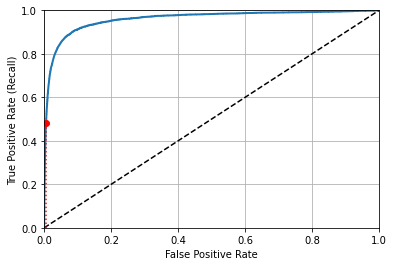

In [26]:
# We can then plot the ROC curve using Matplotlib

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--") # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    
    plt.grid()

plot_roc_curve(fpr, tpr)
# We highlight the chosen ratio (at 43.68% recall)
fpr_90_precision = fpr[np.argmin(thresholds >= threshold_90_precision)]
plt.plot([fpr_90_precision, fpr_90_precision], [0., recall_90_precision], "r:")
plt.plot(fpr_90_precision, recall_90_precision, "ro")
plt.show()

We can compare two classifiers by measuring the area under the (ROC) curve. A perfect classifier will have a "ROC AUC" of 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 

In [27]:
# We get the ROC AUC of our classifier by using Scikit-Learn's roc_auc_score()

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Rule of thumb: Use the PR curve when the positive class is rare, or when you care more about false positives than false negatives. Otherwise, use the ROC curve. 
Why is the ROC curve not as suitable in our case? 
Because it makes our classifier look really good, but mostly just because positives are rare, so the FPR tends to be low.

But anyways, now that we have a nice way of comparing two classifiers, let's train a second classifier.

In [28]:
# The RandomForestClassifier has a predict_proba() method, which returns an array containing a row per 
# instance and a column per class, instead of a decision_function() method. 

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [29]:
# roc_curve() expects labels and scores, but we can just use the positive class probability as score

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

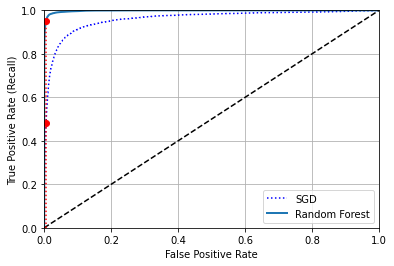

In [30]:
# Now we plot the ROC curve

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
# We highlight the TPR we get for the FPR for which we got 90% precision with the SGD classifier.
# The np.min() usage serves the same purpose as the np.argmax() equivalent we used for the SGD's fpr. 
plt.plot([fpr_90_precision, fpr_90_precision], [0., np.min(tpr_forest[fpr_forest >= fpr_90_precision])], "r:")
plt.plot(fpr_90_precision, np.min(tpr_forest[fpr_forest >= fpr_90_precision]), "ro")
# We compare it to the according "old" TPR value
plt.plot(fpr_90_precision, recall_90_precision, "ro")
plt.legend(loc="lower right")
plt.show()

In [31]:
# We evaluate the ROC AUC of our Random Forest Classifier

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Nice! Our Random Forest Classifier looks much better than our Stochastic Gradient Descent classifier.

In [32]:
# Now let's grab the precision and recall scores for our new classifier

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print("Precision:\t", precision_score(y_train_5, y_train_pred_forest))
print("Recall:\t\t", recall_score(y_train_5, y_train_pred_forest))

Precision:	 0.9905083315756169
Recall:		 0.8662608374838591


Nice, that will do! Let's save this model. 

In [33]:
joblib.dump(forest_clf, "models/digits/random_forest_classifier.pkl", compress=9)

['models/digits/random_forest_classifier.pkl']

We found a really good classifier to determine whether a digit is a 5 or not. But we obviously want to be able to identify each digit, not just one of them. What we need is "Multiclass Classification".

Using an algorithm which supports this natively would be relatively easy. But even strictly binary classifiers (like Support Vector Machines) can work. There are two main approaches:
- One versus the Rest: Train 10 binary classifiers, one for each digit. Then always choose the class with the highest decision score
- One versus One: Train 10*(10-1)/2 = 45 classifiers, one to distinguish between each pair of digits. Then always choose the class which "won the most duels". 

In [34]:
# Scikit-Learn detects automatically if OvR or OvO is preferable for the binary classifier we want to train
# for Multiclass Classification. 

from sklearn.svm import SVC 

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # NOT y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

That worked! Under the hood, Scikit-Learn used the OvO strategy, trained 45 classifiers and let them battle it out.

In [35]:
# We call decision_function() and observe a score for each of our 10 classes. 

some_digit_scores = svm_clf.decision_function([some_digit])

In [36]:
# We can confirm that class 5 indeed got the highest score

print("Argmax:\t", np.argmax(some_digit_scores))
print("Classes:", svm_clf.classes_)
print("Winner:\t", svm_clf.classes_[5])

Argmax:	 5
Classes: [0 1 2 3 4 5 6 7 8 9]
Winner:	 5


The fact that the class "5" actually corresponds to index 5 is very convenient and occurs because the values in the classes_ attribute are automatically ordered by value.

In [37]:
joblib.dump(svm_clf, "models/digits/multiclass_support_vector_machine_classifier.pkl", compress=9)

['models/digits/multiclass_support_vector_machine_classifier.pkl']

In [ ]:
# If for some reason, we want to force Scikit-Learn to use the OneVsOneClassifier or OneVsRestClassifier, 
# we can. We simply create an instance of the corresponding class, passing our classifier of choice to its 
# constructor. 

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
# In fact, I won't use the entire training set here. I tried and it was actually taking ages. 
ovr_clf.fit(X_train[:1000], y_train[:1000])

print("Winner:\t\t\t", ovr_clf.predict([some_digit]))
print("Num. Estimators:\t", len(ovr_clf.estimators_))

In [39]:
# We save the classifier, because that's how we roll. 

joblib.dump(ovr_clf, "models/digits/multiclass_ovr_support_vector_machine_classifier.pkl", compress=9)

['models/digits/multiclass_ovr_support_vector_machine_classifier.pkl']

In [40]:
# Training a classifier which can deal with Multiclass Classification natively is even easier

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [41]:
# We can inspect how confident the SGD classifier was about its prediction

sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Not all that confident. And in fact it was wrong! Let's see if this is just an outlier. 

In [42]:
# To evaluate this classifier, we can use cross_val_score()

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Those results are pretty decent, but we can still do much better.

In [43]:
# For starters, we can scale the input data using the StandardScaler class. 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

That's alright. But we're making errors. We should figure out why this occurs, by analyzing our errors. 

In [44]:
# Getting a confusion matrix works just like it did for binary classifiers

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

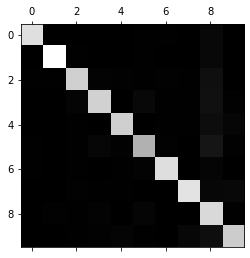

In [47]:
# Visualizing this matrix is a bit more convenient

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The matrix looks pretty good, since most images are on the main diagonal / classified correctly. The 5 square is a bit darker, because the classifier doesn't perform as well on them and because there aren't as many of them in the dataset. 

But we mostly care about what errors occur. So let's focus on that.

In [48]:
# We divide each value in the confusion matrix by the number of images in the corresponding class, because
# we want to treat all classes fairly, regardless of how abundant they are. 

row_sums = conf_mx.sum(axis = 1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

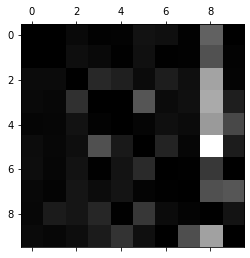

In [51]:
# The matrix would still be dominated by the main diagonal, so we just set it to 0. We care about errors. 

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

It looks like digits tend to be misclassified as 8s quite often. Maybe we could write an algorithm to count the number of closed loops in a digit. That should help our classifier find exactly the "real 8s" reliably. 

Also, 3s and 5s apparently get mistaken for one another quite frequently. Let's take a closer look at this error source.

In [52]:
# We can extract all 3s and all 5s from the dataset that were classified either correctly or as the 
# corresponding counterpart. 

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [53]:
# We write method plot_digits(), which does exactly what its name suggests

# the ** operator allows an arbitrary number of keyword parameters to be passed to the method
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    
    # Fill up the grid with blank images
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        # rimages consists of all images in the current row
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        # the row is concatenated (along the rows) and appended to row_images
        row_images.append(np.concatenate(rimages, axis=1))
    
    # we concatenate the rows and get a 2D matrix
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

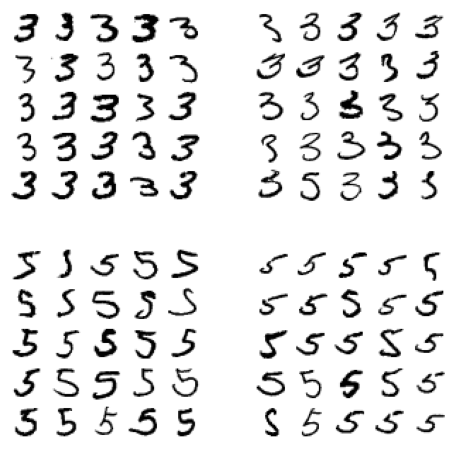

In [54]:
# We then use it to compare real 3s, fake 5s, fake 3s and real 5s

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

We identify image shifting and rotations as a possible error source. Preprocessig the images, ensuring that they're well centered and not too rotated, would be a promising way of addressing this. 

So far, we have only seen instances that were assigned one class. But sometimes, we may want our classifier to return a binary vector - e.g. for face recognition, where more than one face may appear in an image.
For illustration purposes, we can let a classifier decide whether a digit is "large" and whether it is odd. 

In [58]:
# We define and assign the binary labels we want to consider to our training data, before fitting a K
# Neighbours classifier to the adapted training data. 

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

# K Neighbours Classifiers support multilabel classification, though not all classifiers do
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [59]:
# Now we can observe that our new classifier outputs two labels when it makes a prediction

knn_clf.predict([some_digit])

array([[False,  True]])

Also notice that both predictions it makes are indeed correct!

In [60]:
# We now want to evaluate our multilabel classifier, e.g. by computing the average F_1 score across all labels

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

That's really good! Note however that our way of evaluating the classifier assumes that all labels are equally important - if that's not the case, Scikit-Learn provides a few different averaging options and multilabel classifier metrics. An easy way of addressing the problem might be to set average="weighted" when calling the f1_score() method. Then, each label would be given a weight corresponding to its "support" - i.e. the number of instances with that target label. 

In [61]:
joblib.dump(sgd_clf, "models/digits/multilabel_k_neighbours.pkl", compress=9)

['models/digits/multilabel_k_neighbours.pkl']